In [1]:
### Essential libraries.

import numpy as np

import pandas as pd


from hazm import *

import re

import ast


from gensim.models import Word2Vec


from sklearn import preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import KernelPCA

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics


import matplotlib.pyplot as plt

In [2]:
### Hyperparameters.

FLAGS = {
"pca_n_component": 128,
"w2v_size": 100,
"w2v_window": 5,
"w2v_min_count": 2,
"n_epoch": 300,
"max_n_center": 30
}

data_path = "./Raw_Data/hamshahri.json"
preprocessing_path = "./Data"
result_path = "./Results/"
visualization_path = "./Data/"

In [3]:
### Reading and Cleaning data.

data = pd.read_json(data_path, encoding='utf-8')

data['major_label'], data['minor_label'] = zip(*data['tags'].map(lambda x: x[0].split('>')))

le = preprocessing.LabelEncoder()
le.fit(data['major_label'])
data['major_label_number'] = le.transform(data['major_label'])

In [4]:
### Exploration.

data.head(5)

,link,summary,tags,title,major_label,minor_label,major_label_number
0,https://www.hamshahrionline.ir/news/503910/پرت...,رئیس مرکز اطلاعات و کنترل ترافیک پلیس راهور نا...,[اجتماع > سفر],پرترافیک‌ترین جاده‌های ایران پس از پایان ممنوع...,اجتماع,سفر,0
1,https://www.hamshahrionline.ir/news/503441/نخس...,معاون حج و عمره سازمان حج و زیارت اعلام کرد: د...,[اجتماع > سفر],نخستین کاروان حج ۹۹ ششم تیر اعزام می‌شود,اجتماع,سفر,0
2,https://www.hamshahrionline.ir/news/503002/ممن...,رییس مرکز اطلاعات و کنترل ترافیک پلیس راهور نا...,[اجتماع > سفر],ممنوعیت ترددهای بین استانی لغو شد,اجتماع,سفر,0
3,https://www.hamshahrionline.ir/news/502442/نکا...,ممکن است با شروع فعالیت کسب‌وکارها برخی مجبور ...,[اجتماع > سفر],نکات ضدکرونایی که باید در سفرهای ضروری رعایت کنید,اجتماع,سفر,0
4,https://www.hamshahrionline.ir/news/499583/چطو...,رییس پلیس مهاجرت و گذرنامه نیروی انتظامی از فر...,[اجتماع > سفر],چطور بفهمیم ممنوع الخروجیم؟ | امکان اطلاع از م...,اجتماع,سفر,0


In [5]:
### PreProcessing Functions.

def prepare_text_persian(pages_data):
    
    # tokenize, normalization, delete punct

    tokenized_pages=[]
    for page in pages_data:
        tokenized_page = ""
        for letter in page:
            m = re.search('^[آ-ی]$', letter)
            if m is None:
                tokenized_page += " "
            else:
                tokenized_page += letter
        tokenized_pages.append(tokenized_page)

    
    # lemmatize, stemming

    lemmatizer = Lemmatizer()
    tokenized_lemmatized_pages = []
    for tokenized_page in tokenized_pages:
        tokenized_lemmatized_page = []
        for word in tokenized_page.split():
            if len(lemmatizer.lemmatize(word).split("#")) == 1:
                tokenized_lemmatized_page.append(lemmatizer.lemmatize(word).split("#")[0])
            else:
                tokenized_lemmatized_page.append(lemmatizer.lemmatize(word).split("#")[1])
        tokenized_lemmatized_pages.append(tokenized_lemmatized_page)

        
    return tokenized_lemmatized_pages


def remove_stopwords_persian(tokenized_lemmatized_pages):
    
    # remove stopwords

    list_of_words_frequency = []
    for tokenized_lemmatized_page in tokenized_lemmatized_pages:
        for word in tokenized_lemmatized_page:
            flag = 0
            for i in range(len(list_of_words_frequency)):
                if list_of_words_frequency[i][0] == word:
                    flag = 1
                    list_of_words_frequency[i][1] += 1
                if i > 2000:
                    flag = 1
                    break
            if flag == 0:
                list_of_words_frequency.append([word, 1])

    list_of_words_frequency = sorted(list_of_words_frequency, key=lambda l: l[1], reverse=True)

    number_of_stop_words = 13

    stop_words = [i[0] for i in list_of_words_frequency][:number_of_stop_words]
    with open(preprocessing_path + "/stop_words_persian.txt", 'w', encoding='utf-8') as f:
        for page in stop_words:
            f.write("%s\n" % page)


    tokenized_lemmatized_removed_stop_words_pages = []
    for tokenized_lemmatized_page in tokenized_lemmatized_pages:
        temp = [word for word in tokenized_lemmatized_page if word not in stop_words]
        tokenized_lemmatized_removed_stop_words_page = temp
        tokenized_lemmatized_removed_stop_words_pages.append(tokenized_lemmatized_removed_stop_words_page)
        
    return tokenized_lemmatized_removed_stop_words_pages


def remove_stopwords_title_persian(title_tokenized_lemmatized_pages):

    with open(preprocessing_path + "/stop_words_persian.txt", encoding='utf-8') as f:
        lines = f.read().splitlines()
    stop_words = lines

    tokenized_lemmatized_removed_stop_words_title = [word for word in title_tokenized_lemmatized_pages if
                                                     word not in stop_words]
    
    return tokenized_lemmatized_removed_stop_words_title


def merge_text_title_and_add_id_persian(title_tokenized_lemmatized_removed_stop_words_pages, 
                                        text_tokenized_lemmatized_removed_stop_words_pages):
    merged_id_text_title = []
    for i in range(len(title_tokenized_lemmatized_removed_stop_words_pages)):
        merged_id_text_title.append([i+1, text_tokenized_lemmatized_removed_stop_words_pages[i],
                                    title_tokenized_lemmatized_removed_stop_words_pages[i]])
    return merged_id_text_title


def string_preProcess_persian(str):
    
    tokenized_str = ""
    for letter in str:
        m = re.search('^[آ-ی]$', letter)
        if (m is None):
            tokenized_str += " "
        else:
            tokenized_str += letter
            
    lemmatizer = Lemmatizer()
    tokenized_lemmatized_str = []
    for word in tokenized_str.split():
        if (len(lemmatizer.lemmatize(word).split("#")) == 1):
            tokenized_lemmatized_str.append(lemmatizer.lemmatize(word).split("#")[0])
        else:
            tokenized_lemmatized_str.append(lemmatizer.lemmatize(word).split("#")[1])
            
    with open(preprocessing_path + "/stop_words_persian.txt", encoding='utf-8') as f:
        lines = f.read().splitlines()
    stop_words = lines

    tokenized_lemmatized_removed_stop_words_str = [word for word in tokenized_lemmatized_str if
                                                   word not in stop_words]
    
    return tokenized_lemmatized_removed_stop_words_str

In [6]:
### PreProcessing.

data_terms_title = prepare_text_persian(data["title"])
data_terms_summary = prepare_text_persian(data["summary"])

data_terms = [data_terms_title[i] + data_terms_summary[i] for i in range(len(data_terms_title))]

In [7]:
### TF-IDF.

vectorizer = TfidfVectorizer(smooth_idf=True)

strings = [" ".join(x) for x in data_terms]
X_tfidf = vectorizer.fit_transform(strings)

print(X_tfidf.shape)

(2203, 6975)


In [10]:
### PCA.

pca = KernelPCA(n_components=FLAGS["pca_n_component"], kernel='cosine')
X_tfidf = pca.fit_transform(X_tfidf)

print(X_tfidf.shape)

(2203, 128)


In [9]:
### Word2Vec.
                                
model = Word2Vec(data_terms, size=FLAGS["w2v_size"], window=FLAGS["w2v_window"],
                 min_count=FLAGS["w2v_min_count"], workers=1, sg=1)

model.train(data_terms, total_examples=X_tfidf.shape[1], epochs=FLAGS["n_epoch"])


X_w2v = np.zeros((len(data_terms), FLAGS["w2v_size"]))
for i, x in zip(range(len(data_terms)), data_terms):
    cnt = 0
    for y in x:
        if y in model.wv:
            X_w2v[i] += model.wv[y]
            cnt += 1
    X_w2v[i] /= cnt
    
print(X_w2v.shape)

(2203, 100)


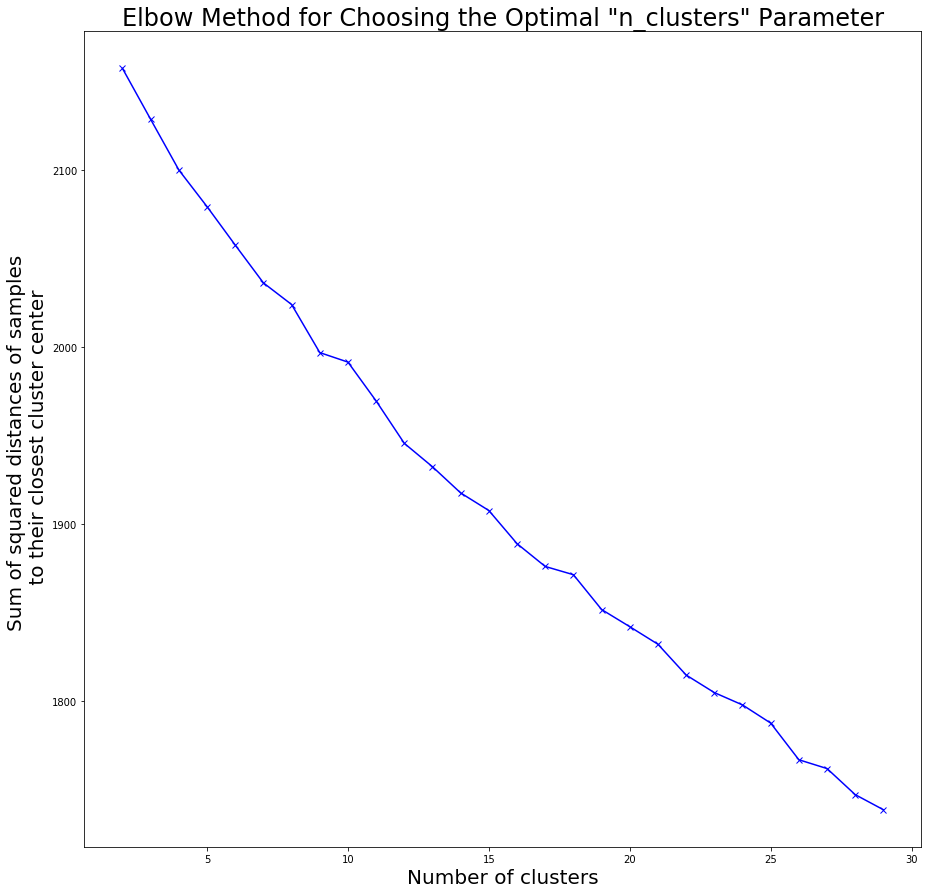

29
2
29


In [25]:
### Choosing the best parametrs for the KMeans clustring (TF-IDF).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
distances = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    kmeans = KMeans(n_clusters=x, init="k-means++", n_init=3, max_iter=1000)
    kmeans.fit(X_tfidf)
    distances.append(kmeans.inertia_)
    
    labels = kmeans.predict(X_tfidf)
    metric1 += [metrics.davies_bouldin_score(X_tfidf, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_tfidf, labels)]
    metric3 += [metrics.silhouette_score(X_tfidf, labels, metric='euclidean')]

    
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, distances, 'bx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Sum of squared distances of samples \n to their closest cluster center', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
print(np.argmax(metric2) + 2)
print(np.argmax(metric3) + 2)

In [28]:
### KMeans Clustring (TF-IDF).

kmeans = KMeans(n_clusters=9, init="k-means++", n_init=10, max_iter=2000)
kmeans.fit(X_tfidf)
y_kmeans_tfidf = kmeans.predict(X_tfidf)

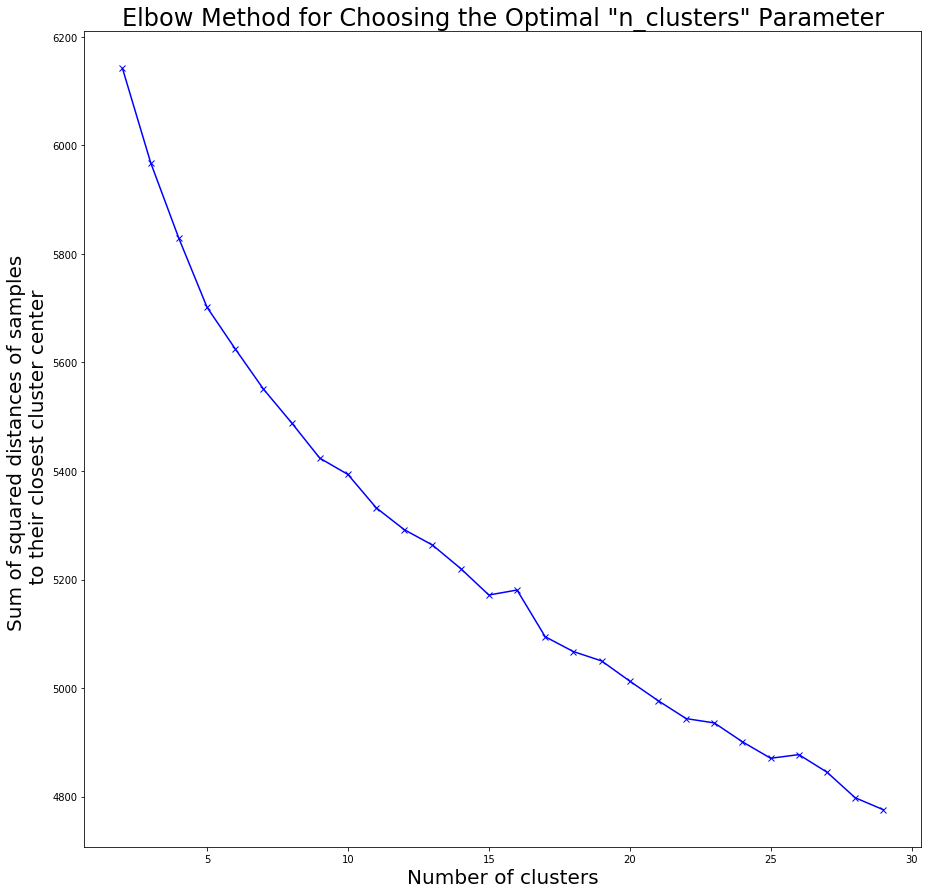

29
2
2


In [30]:
### Choosing the best parametrs for the KMeans clustring (W2V).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
distances = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    kmeans = KMeans(n_clusters=x, init="k-means++", n_init=3, max_iter=1000)
    kmeans.fit(X_w2v)
    distances.append(kmeans.inertia_)
    
    labels = kmeans.predict(X_w2v)
    metric1 += [metrics.davies_bouldin_score(X_w2v, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_w2v, labels)]
    metric3 += [metrics.silhouette_score(X_w2v, labels, metric='euclidean')]


plt.figure(figsize=(15, 15))
plt.plot(n_clusters, distances, 'bx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Sum of squared distances of samples \n to their closest cluster center', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
print(np.argmax(metric2) + 2)
print(np.argmax(metric3) + 2)

In [31]:
### KMeans Clustring (W2V).

kmeans = KMeans(n_clusters=15, init="k-means++", n_init=10, max_iter=2000)
kmeans.fit(X_w2v)
y_kmeans_w2v = kmeans.predict(X_w2v)

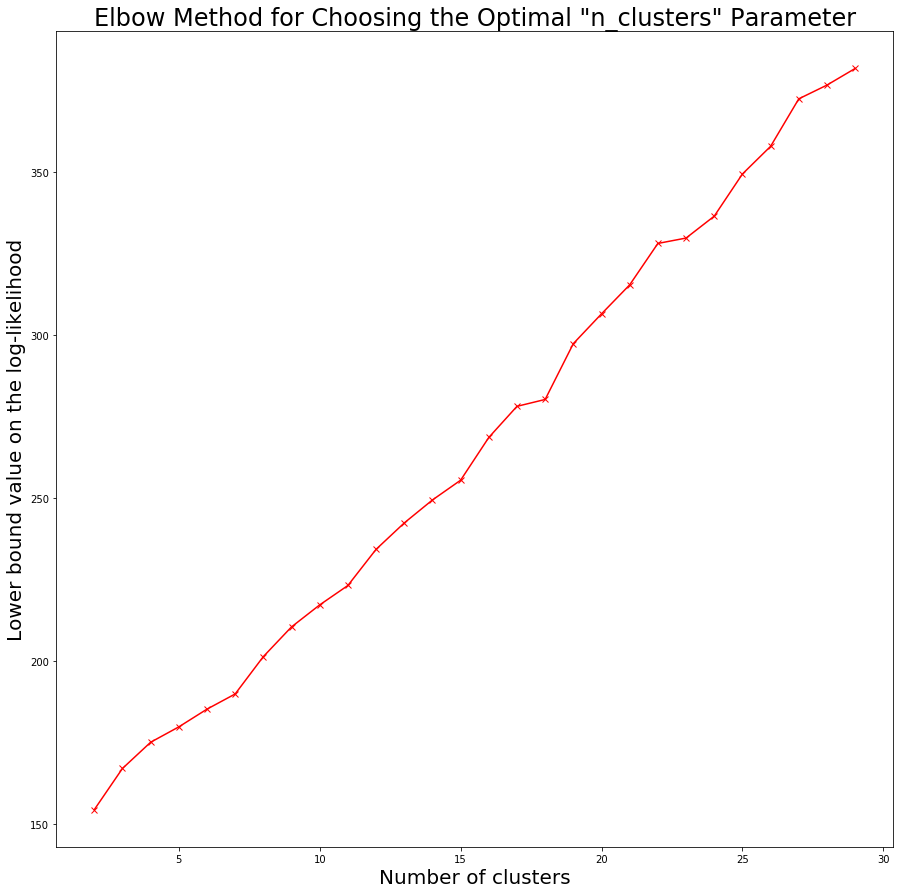

28


In [33]:
### Choosing the best parametrs for the GMM clustring (TF-IDF).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
lower_bounds = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    gmm = GaussianMixture(n_components=x, max_iter=500, n_init=2)
    gmm.fit(X_tfidf)
    lower_bounds.append(gmm.lower_bound_)
    
    labels = gmm.predict(X_tfidf)
    metric1 += [metrics.davies_bouldin_score(X_tfidf, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_tfidf, labels)]
    metric3 += [metrics.silhouette_score(X_tfidf, labels, metric='euclidean')]

    
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, lower_bounds, 'rx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Lower bound value on the log-likelihood', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
print(np.argmax(metric2) + 2)
print(np.argmax(metric3) + 2)

In [38]:
### GMM Clustring (TF-IDF).

gmm = GaussianMixture(n_components=7, max_iter=2000, n_init=2)
gmm.fit(X_tfidf)
y_gmm_tfidf = gmm.predict(X_tfidf)

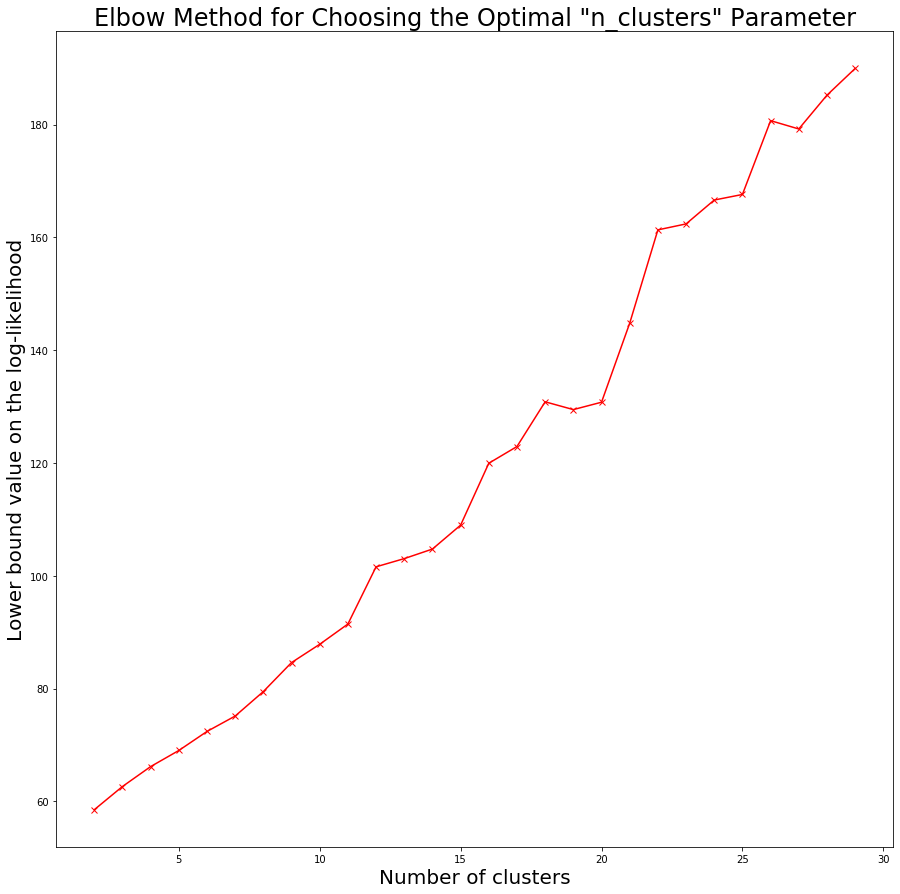

19
2
2


In [35]:
### Choosing the best parametrs for the GMM clustring (W2V).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
lower_bounds = []
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    gmm = GaussianMixture(n_components=x, max_iter=500, n_init=2)
    gmm.fit(X_w2v)
    lower_bounds.append(gmm.lower_bound_)
    
    labels = gmm.predict(X_w2v)
    metric1 += [metrics.davies_bouldin_score(X_w2v, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_w2v, labels)]
    metric3 += [metrics.silhouette_score(X_w2v, labels, metric='euclidean')]


plt.figure(figsize=(15, 15))
plt.plot(n_clusters, lower_bounds, 'rx-')
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Lower bound value on the log-likelihood', fontsize=20)
plt.title('Elbow Method for Choosing the Optimal \"n_clusters\" Parameter', fontsize=24)
plt.show()


print(np.argmin(metric1) + 2)
print(np.argmax(metric2) + 2)
print(np.argmax(metric3) + 2)

In [36]:
### GMM Clustring (W2V).

gmm = GaussianMixture(n_components=11, max_iter=2000, n_init=2)
gmm.fit(X_w2v)
y_gmm_w2v = gmm.predict(X_w2v)

In [40]:
### Choosing the best parametrs for the ‬‬‫‪Hierarchical clustring (TF-IDF).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    h = AgglomerativeClustering(n_clusters=x, linkage="average", affinity="cosine")
    labels = h.fit_predict(X_tfidf)
    
    metric1 += [metrics.davies_bouldin_score(X_tfidf, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_tfidf, labels)]
    metric3 += [metrics.silhouette_score(X_tfidf, labels, metric='euclidean')]


print(np.argmin(metric1) + 2)
print(np.argmax(metric2) + 2)
print(np.argmax(metric3) + 2)

29
2
27


In [41]:
### ‬‬‫‪Hierarchical Clustring (TF-IDF).

h = AgglomerativeClustering(n_clusters=15, linkage="average", affinity="cosine")
y_hierarchical_tfidf = h.fit_predict(X_tfidf)

In [42]:
### Choosing the best parametrs for the ‬‬‫‪Hierarchical clustring (W2V).

n_clusters = [i for i in range(2, FLAGS["max_n_center"])]
metric1 = []
metric2 = []
metric3 = []

for x in n_clusters:
    
    h = AgglomerativeClustering(n_clusters=x, linkage="complete", affinity="l1")
    labels = h.fit_predict(X_w2v)
    
    metric1 += [metrics.davies_bouldin_score(X_w2v, labels)]
    metric2 += [metrics.calinski_harabasz_score(X_w2v, labels)]
    metric3 += [metrics.silhouette_score(X_w2v, labels, metric='euclidean')]


print(np.argmin(metric1) + 2)
print(np.argmax(metric2) + 2)
print(np.argmax(metric3) + 2)

3
2
2


In [44]:
### ‬‬‫‪Hierarchical Clustring (W2V).

h = AgglomerativeClustering(n_clusters=15)
y_hierarchical_w2v = h.fit_predict(X_w2v)

In [45]:
### Evaluations.

labels_true = data["major_label_number"]

names = ["Kmeans_(TF-IDF)", "Kmeans_(W2V)", "GMM_(TF-IDF)", "GMM_(W2V)",
         "Hierarchical_(TF-IDF)", "Hierarchical_(W2V)"]
predictions = [y_kmeans_tfidf, y_kmeans_w2v, y_gmm_tfidf, y_gmm_w2v, y_hierarchical_tfidf, y_hierarchical_w2v]

for name, labels_pred in zip(names, predictions):
    
    print(name + ": ")
    
    m1 = metrics.rand_score(labels_true, labels_pred)
    m2 = metrics.adjusted_rand_score(labels_true, labels_pred)
    print(m1, m2)

    m3 = metrics.mutual_info_score(labels_true, labels_pred)
    m4 = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
    m5 = metrics.normalized_mutual_info_score(labels_true, labels_pred)
    print(m3, m4, m5)

    m6 = metrics.homogeneity_score(labels_true, labels_pred)
    m7 = metrics.completeness_score(labels_true, labels_pred)
    m8 = metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)
    print(m6, m7, m8)

    m9 = metrics.fowlkes_mallows_score(labels_true, labels_pred)
    print(m9)
    
    print("\n")

Kmeans_(TF-IDF): 
0.7998559474055484 0.17021175340435485
0.6286006072008611 0.2892638758531082 0.29751787796895535
0.2852387972608855 0.31090170647600013 (0.2852387972608855, 0.31090170647600013, 0.2975178779689553)
0.2866164561290128


Kmeans_(W2V): 
0.8460521384636507 0.20551193795976835
0.8753636555689278 0.35200147284276406 0.36358970721050904
0.39721195528624204 0.335215211318074 (0.39721195528624204, 0.335215211318074, 0.36358970721050904)
0.2954761632129072


GMM_(TF-IDF): 
0.798798434798885 0.22462210467009172
0.6456281880913604 0.31237729756875254 0.31865270238876414
0.2929653674197917 0.34927751143114083 (0.2929653674197917, 0.34927751143114083, 0.3186527023887642)
0.3437722853070907


GMM_(W2V): 
0.8120525928024002 0.20986061144350804
0.7721790442517378 0.34858997056725505 0.3573725138057866
0.35039008764757057 0.3646388839787838 (0.35039008764757057, 0.3646388839787838, 0.3573725138057866)
0.31888231674762296


Hierarchical_(TF-IDF): 
0.8369175383415316 0.20821555464034477


In [46]:
### Saving.

links = data["link"]

for name, labels_pred in zip(names, predictions):
    df = pd.DataFrame(np.array([links, labels_pred]).T, columns=["Link", "Prediction"])
    df.to_csv(path_or_buf=result_path + name + ".csv", index=False)

In [47]:
df.head(5)

,Link,Prediction
0,https://www.hamshahrionline.ir/news/503910/پرت...,2
1,https://www.hamshahrionline.ir/news/503441/نخس...,2
2,https://www.hamshahrionline.ir/news/503002/ممن...,2
3,https://www.hamshahrionline.ir/news/502442/نکا...,5
4,https://www.hamshahrionline.ir/news/499583/چطو...,6


In [48]:
### Saving data for the visualization.

columns = ["tfidf" + str(i) for i in range(FLAGS["pca_n_component"])] + ["w2v" + str(i) for i in range(FLAGS["w2v_size"])] + ["Prediction"]

for name, labels_pred in zip(names, predictions):
    df = pd.DataFrame(np.concatenate([X_tfidf, X_w2v, labels_pred.reshape(-1, 1)], axis=1), columns=columns)
    df.to_csv(path_or_buf=visualization_path + name + ".csv", index=False)

In [49]:
df.head(5)

,tfidf0,tfidf1,tfidf2,tfidf3,tfidf4,tfidf5,tfidf6,tfidf7,tfidf8,tfidf9,...,w2v91,w2v92,w2v93,w2v94,w2v95,w2v96,w2v97,w2v98,w2v99,Prediction
0,-0.029497,0.205551,-0.039122,-0.104555,-0.019707,-0.195103,-0.069836,0.125018,0.028363,-0.079621,...,0.104767,0.446372,-0.211763,-0.159648,-0.617122,-0.166569,-0.151474,-0.121242,-0.046983,2.0
1,-0.068923,-0.017029,-0.157047,-0.179073,-0.258216,0.154228,-0.119137,-0.136763,-0.092959,-0.105231,...,-0.023607,0.235739,-0.269265,-0.435413,-0.175425,0.281268,0.177029,-0.090093,0.127229,2.0
2,-0.062841,0.116436,-0.058861,-0.093999,-0.080618,-0.127329,-0.137163,0.121538,0.015110,-0.094130,...,0.173530,0.685425,-0.417422,-0.299392,-0.748538,-0.266980,-0.339623,0.034179,-0.215578,2.0
3,0.058260,-0.078282,-0.009696,0.087191,-0.093621,-0.143816,0.113437,0.104390,0.165489,-0.074606,...,-0.256299,0.231315,-0.122786,-0.065977,-0.245565,0.182026,0.167046,-0.101657,0.177639,5.0
4,-0.202497,0.040455,-0.117492,-0.125466,-0.100145,-0.007864,-0.213539,-0.050383,-0.028423,-0.096924,...,0.470516,0.230311,-0.532827,-0.714193,-0.416258,0.616883,-0.137775,0.103227,0.010380,6.0
